Fit interpretable models to the training set and test on validation sets.

In [1]:
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
import numpy as np

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

import imodels
from rulevetting.api import validation
from rulevetting.projects.csi_pecarn.dataset import Dataset

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/andy-github/rule-env/lib/python3.8/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
def var_selection(df,method=['rfe',10]):   ## input: a dataframe with outcome as the last column, method: ['rfe',number of
    ## features to choose] or ['lasso',penalty]     output: a dataframe containing the columns we select and the outcome column
    algo=method[0]
    param=method[1]
    X=df.drop(columns=['outcome'])
    y=df.outcome
    if algo=='rfe':
        mymodel=LogisticRegression()
        myrfe = RFE(mymodel,n_features_to_select=param)
        myfit = myrfe.fit(X, y)
        index=np.append(myfit.support_,True)
    
    elif algo=='lasso':
        mylasso = LogisticRegression(penalty='l1', solver='liblinear',C=param)   ## for example C=0.1
        myfit=mylasso.fit(X, y)
        
        index=np.append(myfit.coef_[0]!=0,True)
    
    
    return index
        

In [3]:
df_train, df_tune, _ = Dataset().get_data(load_csvs=True)

In [4]:
def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes



def model_valid(max_num=20,model_name='decision_tree'):
    '''use validation set to select # of features'''
    
    record=np.zeros(max_num)
    sensitivity=np.zeros(max_num)
    for num in range(1,max_num+1):
        index=var_selection(df_train,method=['rfe',num])
        loc_train=df_train.loc[:,index]
        loc_tune=df_tune.loc[:,index]
        loc_=_.loc[:,index]
        X_train = loc_train.drop(columns=outcome_def)
        y_train = loc_train[outcome_def].values
        X_tune = loc_tune.drop(columns=outcome_def)
        y_tune = loc_tune[outcome_def].values
        
        if model_name=='decision_tree':
            model = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
            model.fit(X_train, y_train)
        elif model_name=='logistic':
            model= LogisticRegression()
            model.fit(X_train, y_train)
        elif model_name=='adaboost':
            model= AdaBoostClassifier(n_estimators=50, learning_rate=1)
            model.fit(X_train, y_train)
            
        
        
        stats, threshes = validation.all_stats_curve(y_tune, model.predict_proba(X_tune)[:, 1],
                                                     plot=False)
        sens=stats['sens']
        spec=stats['spec']
        if sens[0]<0.98:
            record[num-1]=0.
            sensitivity[num-1]=sens[0]
            continue
        j=0
        while sens[j]>0.98:
            #print([j, sens[j]], spec[j])
            #print(sens[j])
            cur_pec=spec[j]
            
            j+=1
        record[num-1]=cur_pec
        sensitivity[num-1]=sens[j]
        
    print(record)
    print(sensitivity)
    return np.argmax(record)+1    ## output the optimal number of features via validation

In [5]:
# print(model_valid(20,model_name='adaboost'))   ## output zero when sens<.98, otherwise output spec (adaboost,decision_tree,logistic)

In [6]:
# print(model_valid(20,model_name='decision_tree'))   ## output zero when sens<.98, otherwise output spec (adaboost,decision_tree,logistic)

In [7]:
# print(model_valid(30,model_name='logistic'))   ## output zero when sens<.98, otherwise output spec (adaboost,decision_tree,logistic)

In [8]:
index=var_selection(df_train,method=['rfe',9])

print(df_train.columns[index])

df_train=df_train.loc[:,index]
df_tune=df_tune.loc[:,index]
_=_.loc[:,index]

X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values

processed_feats = df_train.keys().values.tolist()
feature_names=processed_feats

Index(['ArrPtIntub', 'DxCspineInjury', 'FocalNeuroFindings', 'HighriskDiving',
       'IntervForCervicalStab', 'PtExtremityWeakness', 'PtSensoryLoss',
       'PtTenderExt', 'SubInj_TorsoTrunk', 'outcome'],
      dtype='object')


# fit simple models

**decision tree**

100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 2638.52it/s]

{'sens': [1.0, 0.9813084112149533, 0.9532710280373832, 0.9252336448598131, 0.9158878504672897, 0.8411214953271028, 0.8130841121495327, 0.8037383177570093, 0.5887850467289719, 0.5327102803738317, 0.5046728971962616, 0.3925233644859813, 0.04672897196261682, 0.0], 'spec': [0.014388489208633094, 0.7535971223021583, 0.8111510791366906, 0.8435251798561151, 0.8633093525179856, 0.8723021582733813, 0.8992805755395683, 0.9028776978417267, 0.987410071942446, 0.9892086330935251, 0.9892086330935251, 0.9910071942446043, 1.0, 1.0], 'ppv': [0.1633587786259542, 0.43388429752066116, 0.4927536231884058, 0.532258064516129, 0.5632183908045977, 0.5590062111801242, 0.6083916083916084, 0.6142857142857143, 0.9, 0.9047619047619048, 0.9, 0.8936170212765957, 1.0, nan], 'npv': [1.0, 0.995249406175772, 0.9890350877192983, 0.9832285115303984, 0.9815950920245399, 0.9661354581673307, 0.9615384615384616, 0.9598470363288719, 0.9258010118043845, 0.9166666666666666, 0.912106135986733, 0.8944805194805194, 0.844984802431610

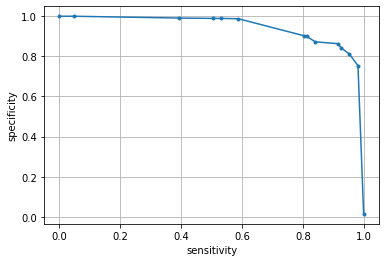

<Figure size 432x288 with 0 Axes>

In [9]:
# fit decision tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
dt.fit(X_train, y_train)

stats, threshes = predict_and_save(dt, model_name='decision_tree')
print(stats,threshes)

plt.show()
plt.savefig("tree-roc.png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0,
        facecolor='auto', edgecolor='auto',
        backend=None)

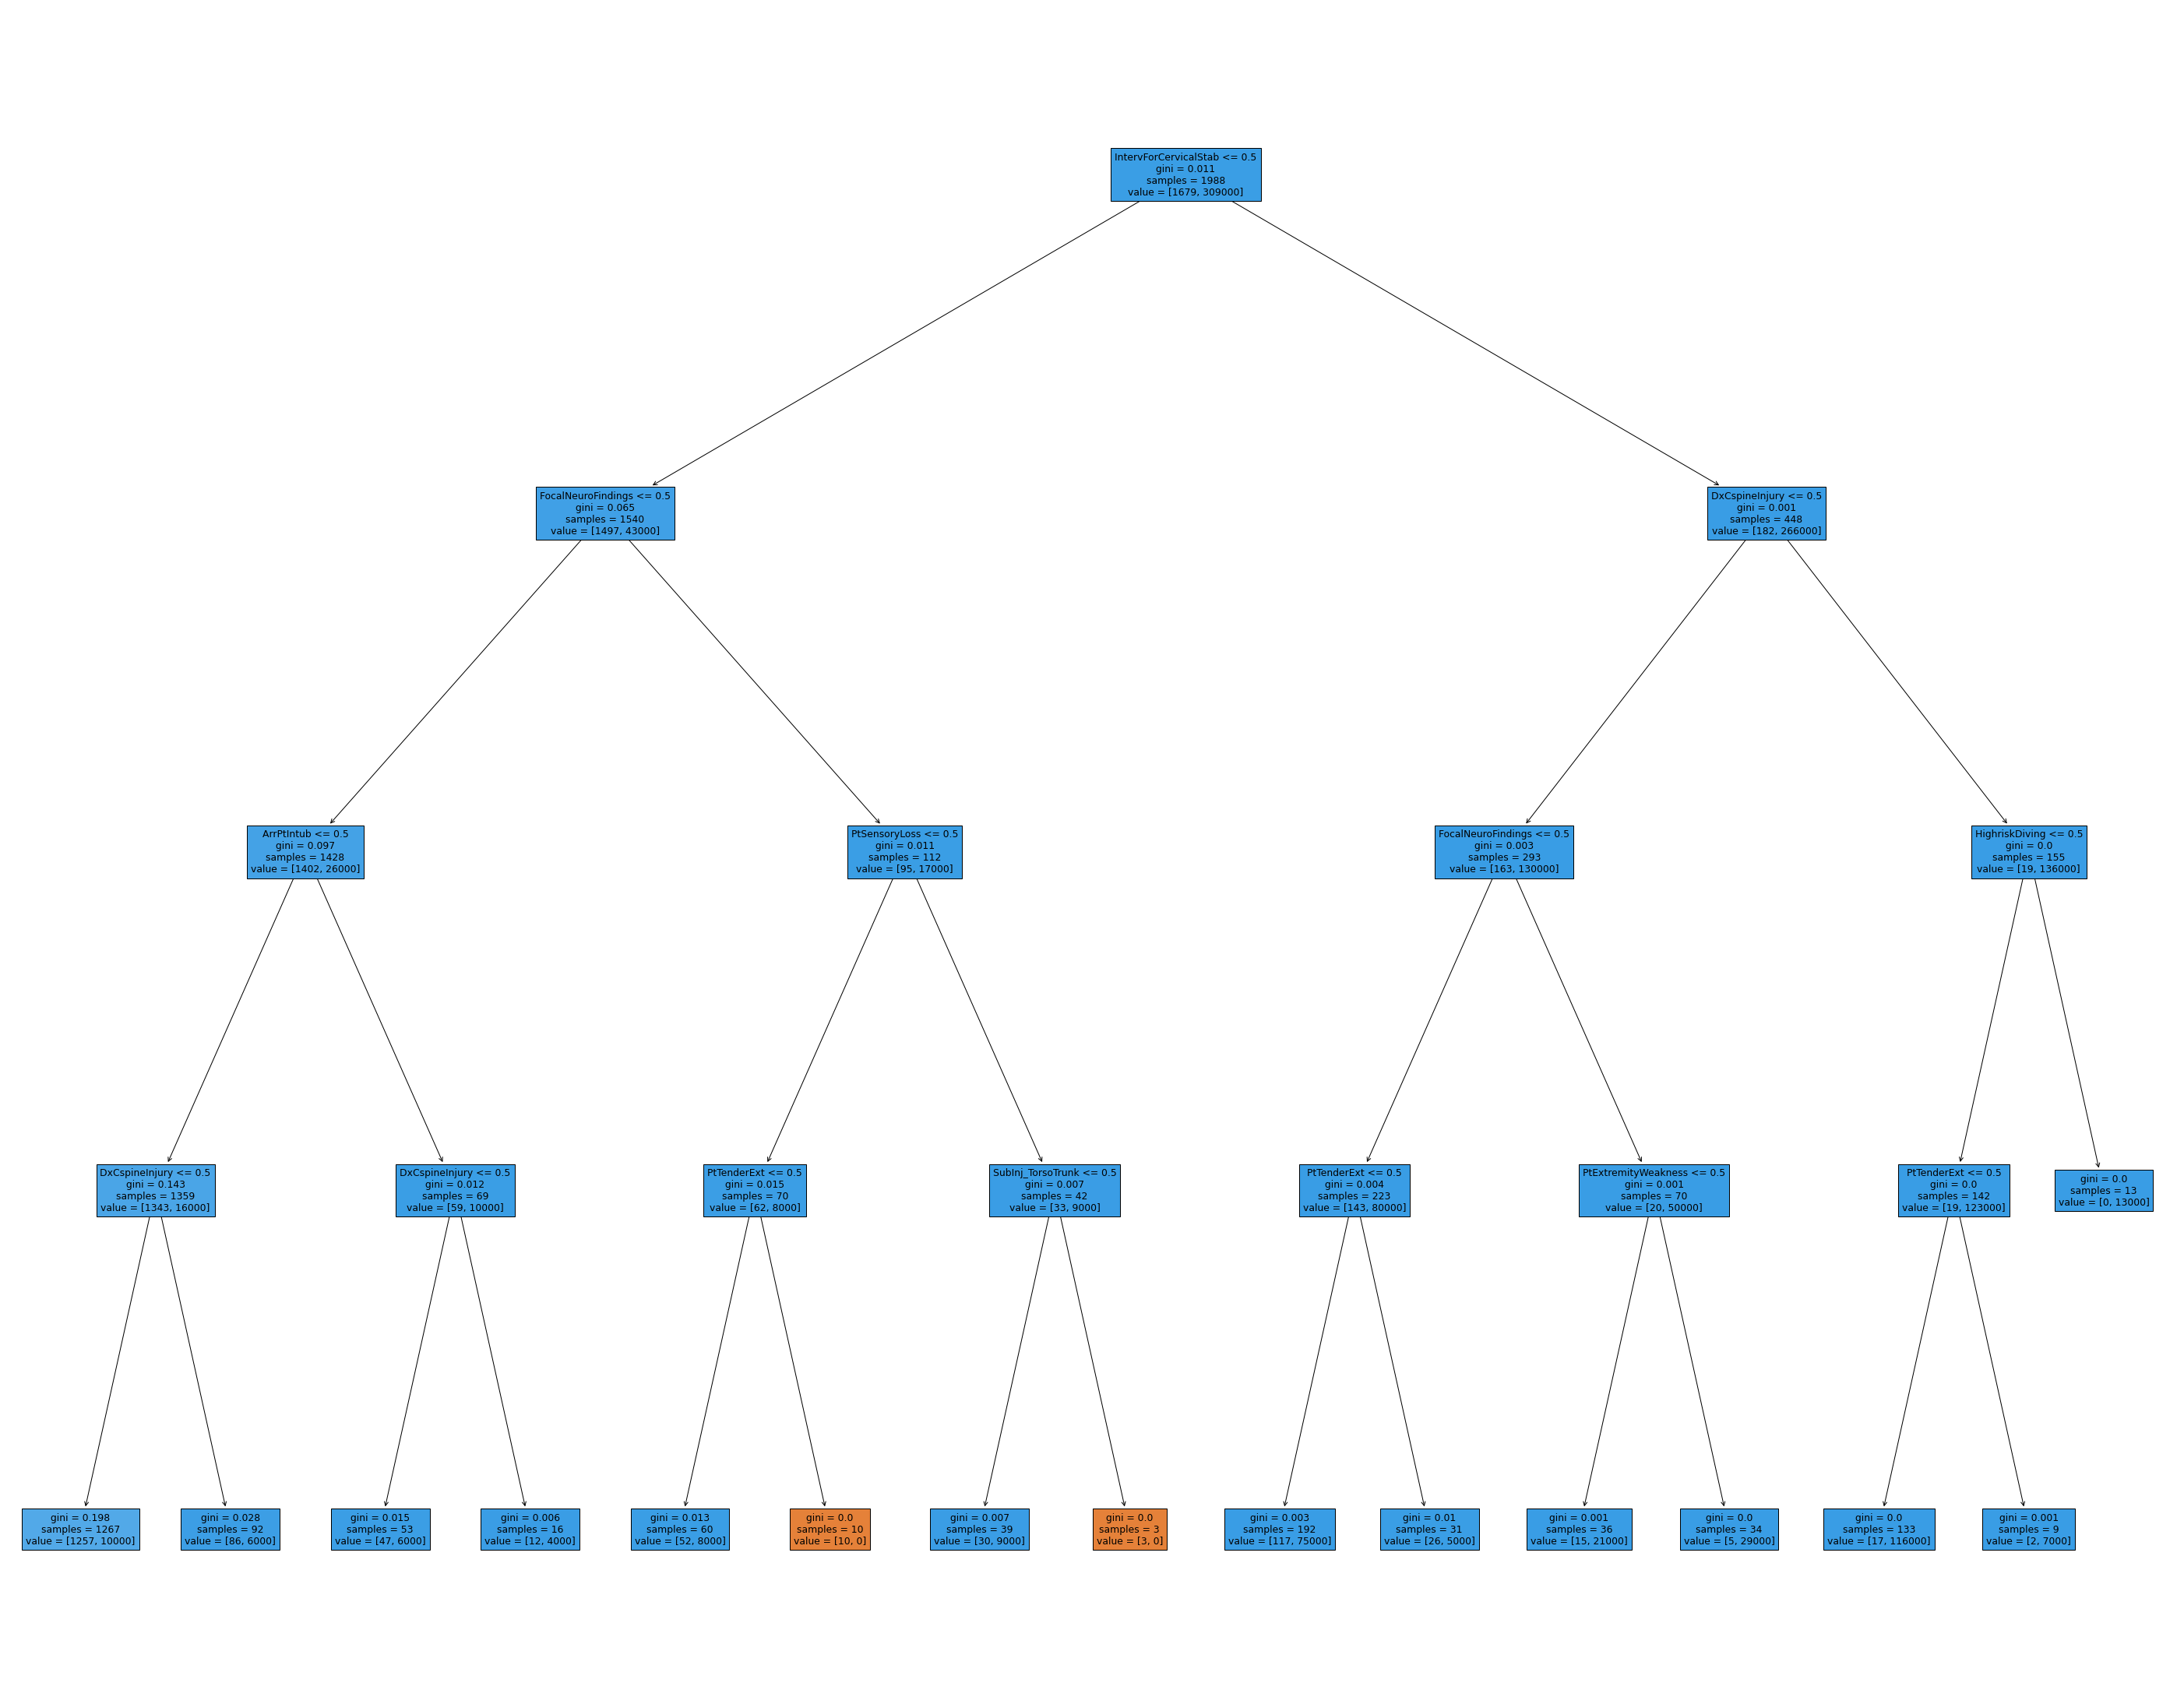

In [10]:
fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 3448.55it/s]

{'sens': [1.0, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9813084112149533, 0.9813084112149533, 0.9813084112149533, 0.9626168224299065, 0.9532710280373832, 0.9532710280373832, 0.9345794392523364, 0.9345794392523364, 0.9252336448598131, 0.9158878504672897, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.8411214953271028, 0.8317757009345794, 0.822429906542056, 0.6915887850467289, 0.6822429906542056, 0.6728971962616822, 0.6728971962616822, 0.6635514018691588, 0.6448598130841121, 0.616822429906542, 0.5887850467289719, 0.5607476635514018, 0.5420560747663551, 0.5233644859813084, 0.4953271028037383, 0.308411214953271, 0.29906542056074764, 0.2897196261682243, 0.21495327102803738, 0.18691588785046728, 0.17757009345794392, 0.1588785046728972, 0.1308411214953271, 0.09345794392523364, 0.07476635514018691, 0.06542056074766354, 0.056074766355140186, 0.009345794392523364, 0.0], 'spec': [0.14568345323741008, 0.7068345323741008, 0

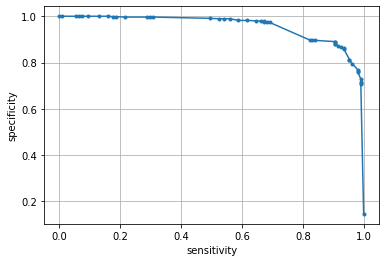

<Figure size 3600x2880 with 0 Axes>

In [11]:
# fit logitstic
dt= LogisticRegression()
dt.fit(X_train, y_train)

stats_lr, threshes_lr = predict_and_save(dt, model_name='logistic')
print(stats_lr, "\n")
print(threshes_lr)

plt.show()
fig = plt.figure(figsize=(50, 40))
plt.show()

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 3513.92it/s]

{'sens': [1.0, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9813084112149533, 0.9813084112149533, 0.9813084112149533, 0.9626168224299065, 0.9439252336448598, 0.9345794392523364, 0.9345794392523364, 0.9345794392523364, 0.9252336448598131, 0.9158878504672897, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.8411214953271028, 0.8317757009345794, 0.7009345794392523, 0.6915887850467289, 0.6822429906542056, 0.6728971962616822, 0.6635514018691588, 0.6448598130841121, 0.6448598130841121, 0.616822429906542, 0.5887850467289719, 0.5607476635514018, 0.5327102803738317, 0.34579439252336447, 0.32710280373831774, 0.308411214953271, 0.2803738317757009, 0.205607476635514, 0.19626168224299065, 0.18691588785046728, 0.16822429906542055, 0.1308411214953271, 0.12149532710280374, 0.102803738317757, 0.07476635514018691, 0.028037383177570093, 0.018691588785046728, 0.009345794392523364, 0.0], 'spec': [0.14568345323741008, 0.7068345323741008, 

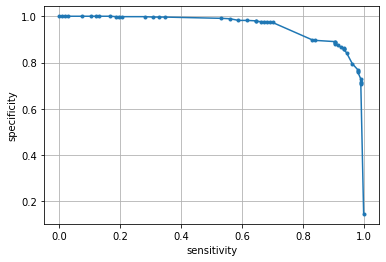

<Figure size 3600x2880 with 0 Axes>

In [12]:
# fit adaboost
dt= AdaBoostClassifier(n_estimators=100, learning_rate=1)
dt.fit(X_train, y_train)

stats_ab, threshes_ab = predict_and_save(dt, model_name='adaboost')
print(stats_ab, "\n")
print(threshes_ab)

plt.show()
fig = plt.figure(figsize=(50, 40))
plt.show()

In [13]:
(np.asarray(stats_lr["sens"]) - np.asarray(stats_ab["sens"])) * 1000

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   9.34579439,  18.69158879,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        , 121.4953271 ,   0.        ,   0.        ,
         0.        ,   9.34579439,  18.69158879,   0.        ,
         0.        ,   0.        ,   0.        ,   9.34579439,
       177.57009346, 168.22429907,   0.        ,  18.69158879,
        84.11214953,  18.69158879,   0.        ,   9.34579439,
        28.03738318,   9.34579439,  -9.34579439,   0.        ,
        37.38317757,  37.38317757,   0.        ,   0.        ])

**bayesian rule list (this one is slow)**

training bayesian_rule_list...


100%|█████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1425.42it/s]

Trained RuleListClassifier for detecting IwI
IF IntervForCervicalStab > 0.5 THEN probability of IwI: 59.3% (54.8%-63.8%)
ELSE IF FocalNeuroFindings > 0.5 THEN probability of IwI: 15.8% (9.7%-23.0%)
ELSE IF DxCspineInjury > 0.5 THEN probability of IwI: 10.0% (5.1%-16.2%)
ELSE probability of IwI: 1.3% (0.8%-2.0%)



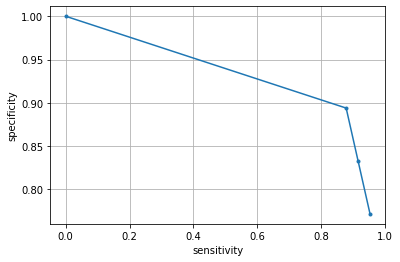

In [14]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=2, max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

In [15]:
print(brl)

Trained RuleListClassifier for detecting IwI
IF IntervForCervicalStab > 0.5 THEN probability of IwI: 59.3% (54.8%-63.8%)
ELSE IF FocalNeuroFindings > 0.5 THEN probability of IwI: 15.8% (9.7%-23.0%)
ELSE IF DxCspineInjury > 0.5 THEN probability of IwI: 10.0% (5.1%-16.2%)
ELSE probability of IwI: 1.3% (0.8%-2.0%)



**rulefit**

100%|█████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1988.09it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

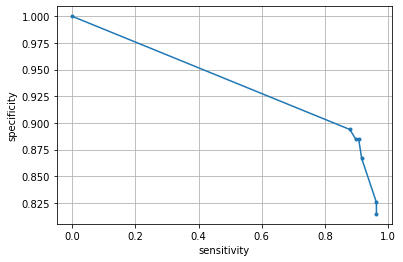

In [16]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [17]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
10,HighriskDiving <= 0.5 and IntervForCervicalStab <= 0.5,-0.06
12,IntervForCervicalStab <= 0.5 and PtSensoryLoss <= 0.5,-0.01
11,HighriskDiving <= 0.5 and IntervForCervicalStab <= 0.5 and PtExtremityWeakness <= 0.5,-0.05
9,ArrPtIntub <= 0.5 and IntervForCervicalStab <= 0.5 and PtSensoryLoss <= 0.5,-0.05


**greedy (CART) rule list**

/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/andy-github/rule-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/seunghoonpaik/Desktop/SH/Berkeley/Coursework/215A/Lab/final-proj/andy-github/rule-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1816.90it/s]

mean 0.155 (1988 pts)
if IntervForCervicalStab >= 1.0 then 0.594 (448 pts)
mean 0.028 (1540 pts)
if feat 2 >= 1.0 then 0.152 (112 pts)
mean 0.018 (1428 pts)
if feat 0 >= 1.0 then 0.145 (69 pts)
mean 0.012 (1359 pts)
if feat 1 >= 1.0 then 0.065 (92 pts)
mean 0.008 (1267 pts)
if feat 8 >= 1.0 then 0.047 (43 pts)
mean 0.007 (1224 pts)
if feat 3 >= 1.0 then 0.007 (1219 pts)
mean 0 (5 pts)



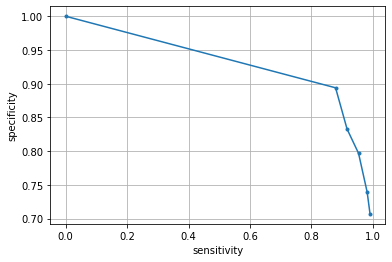

In [18]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

**rf**

# look at all the results

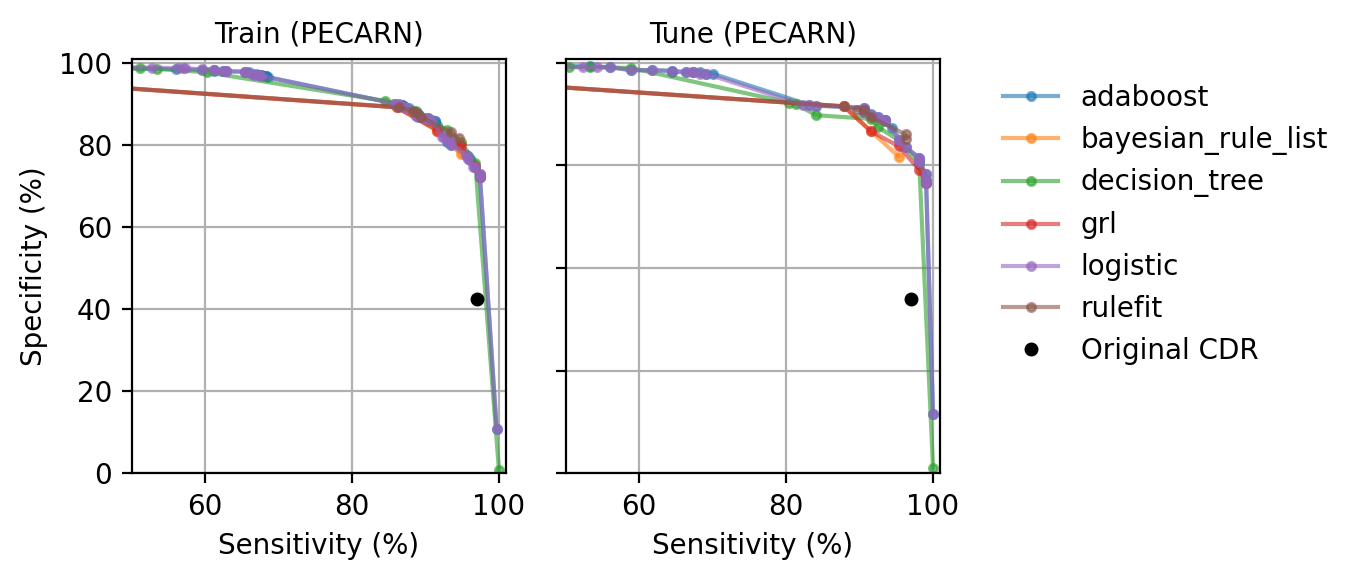

In [19]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
# plt.savefig('figs/metrics_3_splits')
plt.show()